In [19]:
#####   importing necessary library  ######
import nltk
import pandas as pd
import numpy as np
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import sentiwordnet as sentiwordnet
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
import csv
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
lemmatizer = WordNetLemmatizer()
sentimentData = 'wordwithStrength.txt'
data = pd.read_csv('song_eng_only.csv') ###change the path of file
# Songs Lyrics
Lyrics = data["text"]
#################################SentiWordnet###########################
def lyrics_to_wordNet(word_in_song):
    #print(word_in_song)
    if word_in_song.startswith('J'):
        return wn.ADJ
    elif word_in_song.startswith('N'):
        return wn.NOUN
    elif word_in_song.startswith('R'):
        return wn.ADV
    elif word_in_song.startswith('V'):
        return wn.VERB
    return None
def clean_song_lyrics(text):
    text = text.replace("<br />", " ")
    return text

In [4]:
def sentiwordnet_polarity(text):
    #Return a sentiment polarity: 0 = negative, 1 = positive
    sentiment = 0.0
    tokens_count = 0
    text = clean_song_lyrics(text)
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word, word_in_song in tagged_sentence:
            wn_tag = lyrics_to_wordNet(word_in_song)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            # Take the first sense, the most common
            synset = synsets[0]
            sentiwordnet_synset = sentiwordnet.senti_synset(synset.name())
            sentiment += sentiwordnet_synset.pos_score() - sentiwordnet_synset.neg_score()
            tokens_count += 1
    if not tokens_count:
        return 0
    elif sentiment > 0:
        return 1
    # negative sentiment
    return 0

In [5]:
##############################Vader##########################################
vader = SentimentIntensityAnalyzer()
def vader_polarity(text):
    """ Transform the output to a binary 0/1 result """
    score = vader.polarity_scores(text)
    if score['pos'] > 0:
        return 1
    else:
        return 0
count = 0
predicted_label1 = dict()
predicted_label2 = dict()
voted_label = dict()
for index, row in data.iterrows():
    link = getattr(row , 'link')
    if(sentiwordnet_polarity(Lyrics[index]) > 0) :
        predicted_label1[link] = "Positive"
    else :
        predicted_label1[link] = "Negative"
    data.set_value(index, 'Predicted_label_Sentiword', predicted_label1[link])
    #data.to_csv("Label_SentiWN.csv")
    if(vader_polarity(Lyrics[index]) > 0) :
        predicted_label2[link] = "Positive"
    #    data.set_value(index, 'Predicted_label_Sentistrength', predicted_label2[link])
    else :
        predicted_label2[link] = "Negative"
    data.set_value(index, 'Predicted_label_Vader', predicted_label2[link])
#    data.to_csv("Vader.csv")
#    if(predicted_label1[link] == "Positive" and predicted_label2[link] == "Positive"):
#        voted_label[link] = "Positive"
#    else:
#        voted_label[link] = "Negative"
#    data.set_value(index,'Voted_label',voted_label[link])
    #data.to_csv("Predicted_labels.csv")
print("Runing........")

Runing........


In [6]:
#################################NRC###################################
#reading the songs dataset
dataset = pd.read_csv('song_eng_only.csv')

train_data = dataset[:]

train_data = np.array(train_data['text'])

stemmer = PorterStemmer()
dataset['Splitted']=dataset['text'].apply(lambda x: [y for y in x.split(" ")])
dataset['Stemmed']=dataset['Splitted'].apply(lambda x : [stemmer.stem(y) for y in x])
dataset['OnlyAlpha']=dataset['Stemmed'].apply(lambda x: [y for y in x if y.isalpha()])
filtered_words = stopwords.words('english')
dataset['Lyrics']=dataset['OnlyAlpha'].apply(lambda x: [y for y in x if y not in filtered_words])
dataset=dataset.drop(['Splitted','Stemmed','OnlyAlpha'],axis=1)

senti_try={}
with open('NRC_emotion_lexicon_list.txt','r') as f:
    for lines in f:
        lines=lines.replace("\n","")
        line = lines.split("\t")
        if ((line[2]=='1') and (line[1]=='negative')):
            senti_try.update({line[0]:'Negative'})
        elif ((line[1]=='positive') and (line[2]=='1')):
            senti_try.update({line[0]:'Positive'})
result=[]
for i,j in dataset.iterrows():
    pos=0
    neg=0
    l=j[4]
    for k in l:
        #print(k)
        if ((k in senti_try)):
            if (senti_try[k]=='Negative'):
                neg=neg+1
            else:
                pos=pos+1
    if pos>neg:
        result.append('Positive')
    else:
        result.append('Negative')
#dataset['NRC_sentiment']=result
dataset['sentiment']=result

In [9]:
#### code for majority voting #####
print("Final Step....................")
NRC_data=dataset.loc[:,['link','text','sentiment']]
Senti_data=data.loc[:,['link','Predicted_label_Sentiword','Predicted_label_Vader']]
final_sentiment = pd.merge(NRC_data, Senti_data, how='inner', on='link')
final_sentiment['final_senti_vote']=final_sentiment[['sentiment','Predicted_label_Sentiword','Predicted_label_Vader']].mode(axis=1)
#final_sentiment.head(2)
final_sentiment.to_csv("Final.csv")


Final Step....................


In [10]:
# Reading the data into a dataframe and selecting the columns we need
df = final_sentiment
data_Lyrics = df.loc[:,['text', 'final_senti_vote']]
mapping={'Positive':0,'Negative':1}
data_Lyrics['final_senti_vote']=data_Lyrics['final_senti_vote'].map(mapping)
# Splitting the data into 300 training instances and 104 test instances
n = 11437
all_Ids = np.arange(len(data_Lyrics))
random.shuffle(all_Ids)
test_Ids = all_Ids[0:n]
train_Ids = all_Ids[n:]
data_test = data_Lyrics.loc[test_Ids, :]
data_train = data_Lyrics.loc[train_Ids, :]

In [11]:
# Training a Naive Bayes model
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(data_train['text'])
y_train = data_train['final_senti_vote']
clf = MultinomialNB()
clf.fit(X_train, data_train['final_senti_vote'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
# Testing the Naive Bayes model
X_test = count_vect.transform(data_test['text'])
y_test = data_test['final_senti_vote']
y_predicted = clf.predict(X_test)
print("Accuracy of Naive Bayes: %.2f" % accuracy_score(y_test,y_predicted))

Accuracy of Naive Bayes: 0.73


Confusion matrix Naive Bayes:
[[4015 1350]
 [1690 4382]]


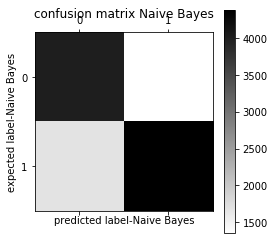

In [13]:
# Reporting on classification performance
#print("Accuracy: %.2f" % accuracy_score(y_test,y_predicted))
classes = [0,1]
cnf_matrix = confusion_matrix(y_test,y_predicted,labels=classes)
print("Confusion matrix Naive Bayes:")
print(cnf_matrix)
plt.matshow(cnf_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix Naive Bayes')
plt.colorbar()
plt.ylabel('expected label-Naive Bayes')
plt.xlabel('predicted label-Naive Bayes')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.show()

In [14]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(y_test,y_predicted)

In [15]:
roc_auc = sklearn.metrics.auc(fpr, tpr)

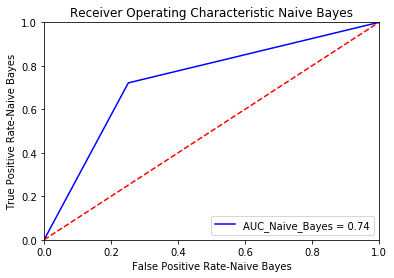

In [16]:
plt.title('Receiver Operating Characteristic Naive Bayes')
plt.plot(fpr, tpr, 'b', label = 'AUC_Naive_Bayes = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate-Naive Bayes')
plt.xlabel('False Positive Rate-Naive Bayes')
plt.show()

Accuracy Logistic Regression: 0.83
Confusion matrix Logistic Regression:
[[4355 1010]
 [ 937 5135]]


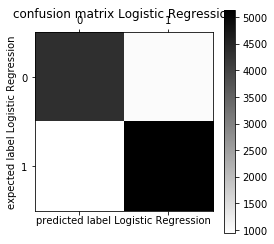

In [17]:
clf_Reg = LogisticRegression()
clf_Reg.fit(X_train, data_train['final_senti_vote'])
y_predicted_Reg = clf_Reg.predict(X_test)

print("Accuracy Logistic Regression: %.2f" % accuracy_score(y_test,y_predicted_Reg))
cnf_matrix_Reg = confusion_matrix(y_test,y_predicted_Reg,labels=classes)
print("Confusion matrix Logistic Regression:")
print(cnf_matrix_Reg)
plt.matshow(cnf_matrix_Reg, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix Logistic Regression')
plt.colorbar()
plt.ylabel('expected label Logistic Regression')
plt.xlabel('predicted label Logistic Regression')
tick_marks_Reg = np.arange(len(classes))
plt.xticks(tick_marks_Reg, classes)
plt.yticks(tick_marks_Reg, classes)
plt.show()



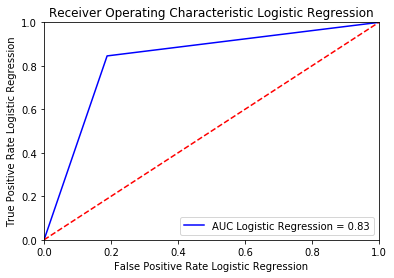

In [18]:
fpr_Reg, tpr_Reg, threshold_Reg=sklearn.metrics.roc_curve(y_test,y_predicted_Reg)
roc_auc_Reg = sklearn.metrics.auc(fpr_Reg, tpr_Reg)
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.plot(fpr_Reg, tpr_Reg, 'b', label = 'AUC Logistic Regression = %0.2f' % roc_auc_Reg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate Logistic Regression')
plt.xlabel('False Positive Rate Logistic Regression')
plt.show()

Accuracy Random Forest Classifier: 0.73
Confusion matrix Random Forest Classifier:
[[ 268 5097]
 [  57 6015]]


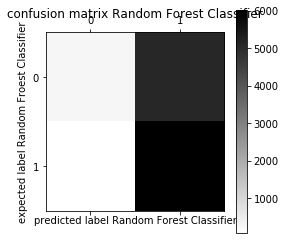

In [20]:
clf_RFC = RandomForestClassifier(max_depth=2, random_state=0)
clf_RFC.fit(X_train, data_train['final_senti_vote'])
y_predicted_RFC = clf_RFC.predict(X_test)
print("Accuracy Random Forest Classifier: %.2f" % accuracy_score(y_test,y_predicted))
cnf_matrix_RFC = confusion_matrix(y_test,y_predicted_RFC,labels=classes)
print("Confusion matrix Random Forest Classifier:")
print(cnf_matrix_RFC)
plt.matshow(cnf_matrix_RFC, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix Random Forest Classifier')
plt.colorbar()
plt.ylabel('expected label Random Froest Classifier')
plt.xlabel('predicted label Random Forest Classifier')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.show()

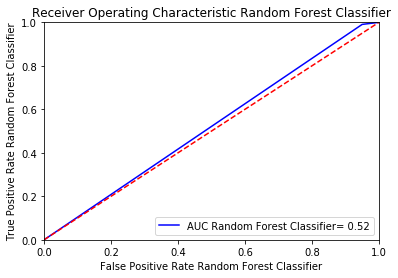

In [24]:
fpr_RFC, tpr_RFC, threshold_RFC=sklearn.metrics.roc_curve(y_test,y_predicted_RFC)
roc_auc_RFC = sklearn.metrics.auc(fpr_RFC, tpr_RFC)
plt.title('Receiver Operating Characteristic Random Forest Classifier')
plt.plot(fpr_RFC, tpr_RFC, 'b', label = 'AUC Random Forest Classifier= %0.2f' % roc_auc_RFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate Random Forest Classifier')
plt.xlabel('False Positive Rate Random Forest Classifier')
plt.show()

In [21]:
### Ensemble of above three models

In [22]:
eclf1 = VotingClassifier(estimators=[('NaiveBayes', clf), ('LogisticReg', clf_Reg), ('RandomForest', clf_RFC)], voting='hard')
eclf1 = eclf1.fit(X_train, data_train['final_senti_vote'])
y_predicted_Ensemble=eclf1.predict(X_test)
print("Accuracy Ensemble Classifier: %.2f" % accuracy_score(y_test,y_predicted_Ensemble))

Accuracy Ensemble Classifier: 0.80


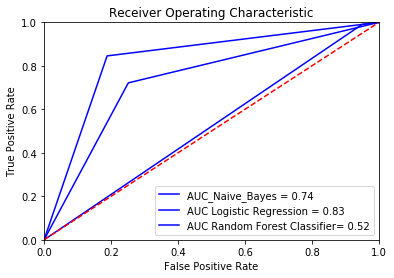

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_Naive_Bayes = %0.2f' % roc_auc)
plt.plot(fpr_Reg, tpr_Reg, 'b', label = 'AUC Logistic Regression = %0.2f' % roc_auc_Reg)
plt.plot(fpr_RFC, tpr_RFC, 'b', label = 'AUC Random Forest Classifier= %0.2f' % roc_auc_RFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()